
# I/ Defining the project topic and RNN models

## Time series and forecasting problems (Sunspots dataset)

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

Due to their link to solar activity, sunspots forecasting is helpful in predict space weather, the state of the ionosphere, and hence the conditions of short-wave radio propagation or satellite communications.

In this project, a recurrent neural network is constructed to forecast the trend of sunspot number in the future, which can contribute to the plan of space travel or the enhancement of the radio range. We will define the LSMT based recurrent neural network model. The lookback period is 11 years as observed from the variation of 

The data exploited in this project is sunspots dataset extracted from kaggle database, covering monthly mean total sunspot number from 1749/01/01 to 2017/08/31.

## Step 1: Loading the datasets and preprocessing the data

In [111]:
import kaggle

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [112]:
api.dataset_download_file('robervalt/sunspots','Sunspots.csv')

False

In [113]:
import pandas as pd

data = pd.read_csv('Sunspots.csv')
data.index = pd.to_datetime(data['Date'].astype(str), format="%Y%m%d %H:%M:%S")

In [114]:
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
Date,,,
1749-01-31,0,1749-01-31,96.7
1749-02-28,1,1749-02-28,104.3
1749-03-31,2,1749-03-31,116.7
1749-04-30,3,1749-04-30,92.8
1749-05-31,4,1749-05-31,141.7


In [115]:
data = data.drop(labels=['Unnamed: 0', 'Date'], axis=1)
data = data.rename(columns={'Monthly Mean Total Sunspot Number': 'value'})

In [116]:
data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   3265 non-null   float64
dtypes: float64(1)
memory usage: 51.0 KB


### We plot the data to observe the trend or seasonality of the dataset. As can be seen from the figure, there is no trend of the sunspot numbers, but, there is indeed seasonality of the phenomenon. However, there is large variation in the seasonality over the time period.

Text(0.5, 1.0, 'Figure of full dataset')

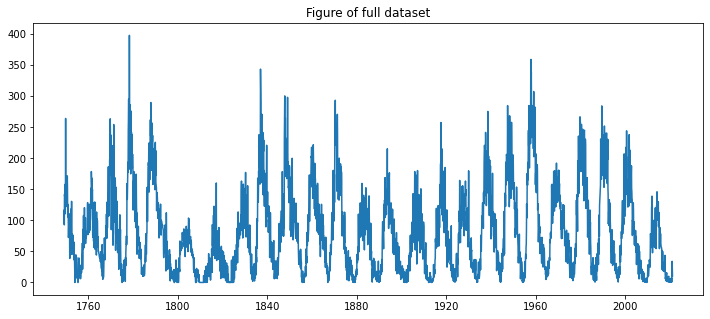

In [133]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, StrMethodFormatter
%matplotlib inline
plt.figure(100, figsize=(12,5))
plt.plot(data)
plt.title('Figure of full dataset')

Text(0.5, 1.0, 'Zoom-in figure')

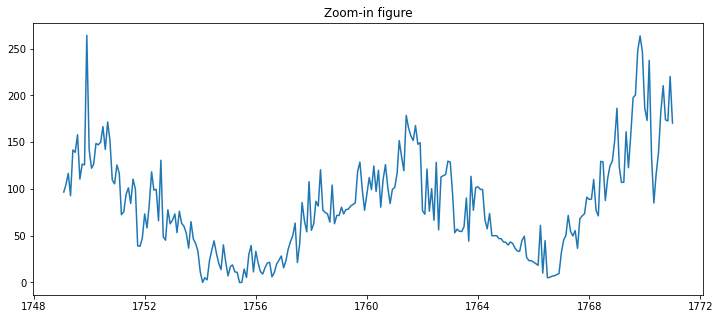

In [136]:
plt.figure(100, figsize=(12,5))
plt.plot(data.index[:264], data['value'][:264])
plt.title('Zoom-in figure')

### In this project, we will assign 50% of the dataset for the training sample, 25% for the validation sample and the other 25% for the test sample

In [118]:
sample = np.array(data.values.astype('float32'))

split_train = int(len(data)*0.5) # choose the split ratio of training sample at 50% of data
train_sample = sample[range(split_train)]

testval_sample = sample[split_train:]
split_test = int(len(testval_sample)*0.5) # choose the split ratio of test sample at 506% of the rest data

test_sample = testval_sample[range(split_test)]
val_sample = testval_sample[split_test:] # validation sample is assigned with the rest data


### As we build the LSTM based recurrent neural network model, the model is sensitive to the scale of the input data. Therefore, we will rescale the data to the range of 0 to 1

In [120]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

train_sample = scaler.fit_transform(train_sample)
test_sample = scaler.transform(test_sample)
val_sample = scaler.transform(val_sample)

### Neural network requires the sequence data, which is data in timeseries, to be stored in the rank - 3 tensors of shape (batch_size, timesteps, input_features). Thus, we will change the shape of the data equivalently for the input digested by the recurrent neural network. As we choose to predict the sunspots number one month ahead, the timestep is set to be 11. We then define input X and target y for training the model.

In [202]:
# Prepare the input X and target Y
def get_XY(sample, time_steps):
    # Indices of target array
    y_ind = np.arange(time_steps, len(sample), time_steps)
    y = sample[y_ind]
    # Prepare X
    rows_x = len(y)
    X = sample[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, y
 
time_steps = 1
X_train, y_train = get_XY(train_sample, time_steps)
X_test, y_test = get_XY(test_sample, time_steps)
X_val, y_val = get_XY(val_sample, time_steps)

## Step 2: Define the Vanilla LSTM-based neural network

In [146]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error

In [203]:
units = 64
num_timesteps = 1 # X_train.shape[1]
num_feature = 1 # X_train.shape[2]
num_epochs = 50
batch_size = 4

In [207]:
model = Sequential()
model.add(LSTM(units,
               input_shape=(num_timesteps, num_feature), 
               return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


M = model.fit(X_train, y_train, 
          epochs=num_epochs, 
          batch_size=batch_size,
          validation_data = (X_val, y_val),
          verbose=2)

def plot_results(H):
    results = pd.DataFrame({"Train Loss": H.history['loss'], "Validation Loss": H.history['val_loss'],
              "Train Accuracy": H.history['mae'], "Validation Accuracy": H.history['val_mae']
             })
    fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
    results[["Train Loss", "Validation Loss"]].plot(ax=ax[0])
    results[["Train Accuracy", "Validation Accuracy"]].plot(ax=ax[1])
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    plt.show()

plot_results(M)